In [15]:
import numpy as np
import pandas 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from bisect import bisect_left
from tqdm import notebook
import math
from sklearn.cluster import KMeans
import collections
from random import *
import matplotlib.pyplot as plt

In [16]:
def G_measure(y_true,y_pred): #OK
    arr = confusion_matrix(y_true,y_pred)
    pd = arr[1][1]/(arr[1][1]+arr[1][0])
    pf = arr[0][1]/(arr[0][0]+arr[0][1])
    fallout = 1-pf
    g_measure = 2*((pd*fallout)/(pd+fallout))
    return g_measure

In [17]:
df = pandas.read_csv('../Dataset/AEEEM/EQ.csv')

In [18]:
df = df.drop_duplicates()

In [19]:
train, test = train_test_split(df, test_size= 0.2)

In [20]:
train_clean = train.loc[train["class"]==False]
train_buggy = train.loc[train["class"]==True]
# print(train['class'].value_counts())
# print(test['class'].value_counts())
# print(train_clean['class'].value_counts())
# print(train_buggy['class'].value_counts())

In [21]:
# Tr = pd.concat([train_clean,train_buggy])
# print(Tr.loc[75,])
# Tr.loc[151,]

In [22]:
X_train_clean =  train_clean.iloc[:, :-1]
y_train_clean = train_clean.iloc[:,-1]

X_train_buggy =  train_buggy.iloc[:, :-1]
y_train_buggy = train_buggy.iloc[:,-1]

X_test = test.iloc[:, :-1]
y_test = test.iloc[:,-1]

In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_train = pandas.concat([X_train_clean,X_train_buggy])
std_scale = StandardScaler().fit(X_train)
X_train_clean = std_scale.transform(X_train_clean)
X_train_buggy = std_scale.transform(X_train_buggy)
X_test = std_scale.transform(X_test)
print(X_train_clean.shape)
print(X_train_buggy.shape)

(110, 61)
(102, 61)


In [24]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_train_clean)
cnt=collections.Counter(kmeans.labels_)
X_train_clean=X_train_clean[kmeans.labels_==cnt.most_common()[0][0]]
y_train_clean=y_train_clean[kmeans.labels_==cnt.most_common()[0][0]]
print(X_train_clean.shape)
print(X_train_buggy.shape)

(80, 61)
(102, 61)


In [25]:
# X_train = pd.concat([X_train_clean,X_train_buggy])
# y_train = pd.concat([y_train_clean,y_train_buggy])
# X_train

In [26]:
class Config:
    __PopulationSize = 50 # Population Size
    __MaxDomain = [1000,1000] # variable upper limit
    __MinDomain = [1,1] # variable lower limit
    for i in range(X_train_buggy.shape[0]):
        __MaxDomain.append(X_train_clean.shape[0]-1)
        __MinDomain.append(0)
    __Lambda = 1.5 # parameter for Levy flight
    __Pa = 0.25
    __Step_Size = 10
    __Dimension = 2+X_train_buggy.shape[0] # The number of dimension
    __Trial = 1
    __Iteration = 200

    @classmethod
    def get_population_size(cls):
        return cls.__PopulationSize

    @classmethod
    def get_Pa(cls):
        return cls.__Pa

    @classmethod
    def get_iteration(cls):
        return cls.__Iteration

    @classmethod
    def get_trial(cls):
        return cls.__Trial

    @classmethod
    def get_dimension(cls):
        return cls.__Dimension

    @classmethod
    def get_max_domain(cls,i):
        return cls.__MaxDomain[i]

    @classmethod
    def get_min_domain(cls,i):
        return cls.__MinDomain[i]

    @classmethod
    def get_lambda(cls):
        return cls.__Lambda

    @classmethod
    def get_stepsize(cls):
        return cls.__Step_Size

def calculation(weights):
    fitness = rmse(weights)
    return fitness

# def evaluation(weights):

    
def rmse(weights):
    X_ltrain_clean = X_train_clean[weights[2:].astype(int)]
    X_ltrain_clean = pandas.DataFrame(X_ltrain_clean)
    X_ltrain_buggy = pandas.DataFrame(X_train_buggy)
    X_ltrain = pandas.concat([X_ltrain_clean,X_ltrain_buggy])
    
    y_ltrain_clean = y_train_clean.to_numpy()
    y_ltrain_clean = y_ltrain_clean[weights[2:].astype(int)]
    y_ltrain_clean = pandas.DataFrame(y_ltrain_clean)
    y_ltrain_buggy = y_train_buggy
    y_ltrain = pandas.concat([y_ltrain_clean,y_ltrain_buggy])

    X_ltest = X_test
    y_ltest = y_test
    
    clf = SVC(kernel="rbf",C=weights[0],gamma=(1/weights[1]))
    clf.fit(X_ltrain, y_ltrain.values.ravel())
    preds = clf.predict(X_ltest)
    g_score = G_measure(y_ltest,preds)
    return g_score

def evaluation(weights):
    X_ltrain_clean = X_train_clean[weights[2:].astype(int)]
    X_ltrain_clean = pandas.DataFrame(X_ltrain_clean)
    X_ltrain_buggy = pandas.DataFrame(X_train_buggy)
    X_ltrain = pandas.concat([X_ltrain_clean,X_ltrain_buggy])
    
    y_ltrain_clean = y_train_clean.to_numpy()
    y_ltrain_clean = y_ltrain_clean[weights[2:].astype(int)]
    y_ltrain_clean = pandas.DataFrame(y_ltrain_clean)
    y_ltrain_buggy = y_train_buggy
    y_ltrain = pandas.concat([y_ltrain_clean,y_ltrain_buggy])

    X_ltest = X_test
    y_ltest = y_test
    
    clf = SVC(kernel="rbf",C=weights[0],gamma=(1/weights[1]))
    clf.fit(X_ltrain, y_ltrain.values.ravel())
    preds = clf.predict(X_ltest)
    arr = confusion_matrix(y_ltest,preds)
    pd = arr[1][1]/(arr[1][1]+arr[1][0])
    pf = arr[0][1]/(arr[0][0]+arr[0][1])
    mcc=matthews_corrcoef(y_ltest,preds)
    fi = (arr[0][1]+arr[1][1])/(arr[0][0]+arr[0][1]+arr[1][1]+arr[1][0])
    FIR = (pd-fi)/pd
    fallout = 1-pf
    g_measure = 2*((pd*fallout)/(pd+fallout))
    return pd,pf,mcc,FIR,g_measure

def levy_flight(Lambda):
    #generate step from levy distribution
    sigma1 = np.power((math.gamma(1 + Lambda) * np.sin((np.pi * Lambda) / 2)) \
                      / math.gamma((1 + Lambda) / 2) * np.power(2, (Lambda - 1) / 2), 1 / Lambda)
    sigma2 = 1
    u = np.random.normal(0, sigma1, size=Config.get_dimension())
    v = np.random.normal(0, sigma2, size=Config.get_dimension())
    step = u / np.power(np.fabs(v), 1 / Lambda)

    return step

def random_set_individul():
    position = np.random.rand(Config.get_dimension())
    for i in range(Config.get_dimension()):
        position[i]=position[i]*(Config.get_max_domain(i)-Config.get_min_domain(i))+Config.get_min_domain(i)
        if i>1:
             position[i]= round(position[i])
    return position
    
    
class Individual:
    def __init__(self):
        self.__position = random_set_individul()
        self.__fitness = calculation(self.__position)
        
    def get_position(self):
        return self.__position

    def set_position(self, position):
        self.__position = position

    def get_fitness(self):
        return self.__fitness
    
#     def get_evaluation(self):
#         return self.__eval
    
    def set_fitness(self, fitness):
        self.__fitness = fitness

    def abandon(self):
        # abandon some variables
        for i in range(len(self.__position)):
            p = np.random.rand()
            if p < Config.get_Pa():
                self.__position[i] = np.random.rand() * (Config.get_max_domain(i) - Config.get_min_domain(i))  + Config.get_min_domain(i)

    def get_cuckoo(self):

        step_size = Config.get_stepsize() * levy_flight(Config.get_lambda())
#         print("step_size :{}".format(step_size))
        # Update position
        self.__position = self.__position + step_size

        # Simple Boundary Rule
        for i in range(len(self.__position)):
            if self.__position[i] > Config.get_max_domain(i):
                self.__position[i] = Config.get_max_domain(i)
            if self.__position[i] < Config.get_min_domain(i):
                self.__position[i] = Config.get_min_domain(i)
        
        for i in range(2,len(self.__position)):
            self.__position[i] = round(self.__position[i])
        
        unique = np.unique(self.__position[2:])
        if len(self.__position[2:])!=len(unique):
            for i in range(2,len(self.__position)):
                if i<len(unique):
                    self.__position[i]=unique[i-2]
                else:
                    item = 0
                    while item in unique:
                        item=randint(Config.get_min_domain(i),Config.get_max_domain(i))
                    self.__position[i]=item
            unique = np.unique(self.__position[2:])              
                        
                        
    def print_info(self,i):
        print("id:","{0:3d}".format(i),
              "|| fitness:",str(self.__fitness).rjust(14," "),
              "|| position:",np.round(self.__position,decimals=4))
        


Comeplete <Generate Initial Population>
Comeplete <Find Initial Best>
iteration 0 : Comeplete <Generate New Solutions>
iteration 0 : Comeplete <Sort to Find the Best>
iteration = 0  best_fitness = 0.7325581395348836
pd = 0.7777777777777778
pf = 0.3076923076923077
mcc = 0.47210735240588764
fir = 0.29649595687331537
g-measure = 0.7325581395348836
best_Position = 612 70 0 2 3 4 5 6 7 12 13 14 18 19 20 21 22 23 24 25 26 27 28 29 31 32 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48 50 52 53 54 56 57 58 59 62 64 65 68 71 17 73 77 66 10 1 66 60 67 49 61 61 1 17 61 39 67 60 66 51 78 8 70 17 77 76 51 16 73 17 15 66 30 74 10 66 49 78 39 1 16 51 49 72 76 30 69 67 72 39
iteration 1 : Comeplete <Generate New Solutions>
iteration 1 : Comeplete <Sort to Find the Best>
iteration = 1  best_fitness = 0.7357212003872218
pd = 0.7407407407407407
pf = 0.2692307692307692
mcc = 0.47150997150997154
fir = 0.3122641509433962
g-measure = 0.7357212003872218
best_Position = 346 108 0 2 3 5 8 10 11 13 15 16 18 19 20 2

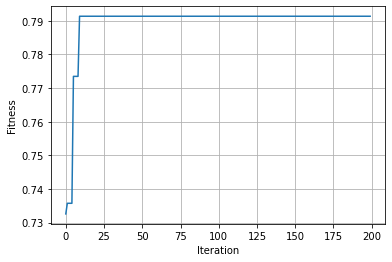

In [27]:
for trial in range(Config.get_trial()):
    np.random.seed(trial)

    results_list = [] # fitness list
    iteration_list = []
    cs_list = []
    """Generate Initial Population"""
    for p in range(Config.get_population_size()):
        cs_list.append(Individual())
    print("Comeplete <Generate Initial Population>")

    """Sort List"""
    cs_list = sorted(cs_list, key=lambda ID: ID.get_fitness())

    """Find Initial Best"""
    BestPosition = cs_list[0].get_position()
    BestFitness = calculation(cs_list[0].get_position())
    print("Comeplete <Find Initial Best>")
    """↓↓↓Main Loop↓↓↓"""
    for iteration in range(Config.get_iteration()):

        """Generate New Solutions"""
        for i in range(len(cs_list)):
            cs_list[i].get_cuckoo()
            cs_list[i].set_fitness(calculation(cs_list[i].get_position()))
            """random choice (say j)"""
            j = np.random.randint(low=0, high=Config.get_population_size())
            while j == i: #random id[say j] ≠ i
                j = np.random.randint(0, Config.get_population_size())

            # for maxmize problem
            if(cs_list[i].get_fitness() > cs_list[j].get_fitness()):
                cs_list[j].set_position(cs_list[i].get_position())
                cs_list[j].set_fitness(cs_list[i].get_fitness())
        print("iteration {} : Comeplete <Generate New Solutions>".format(iteration))
        """Sort (to Keep Best)"""
        cs_list = sorted(cs_list, key=lambda ID: ID.get_fitness(),reverse=True)
#         print("Sort (to Keep Best)")
#         for i in range(len(cs_list)):
#             print("cs_list : {} fitness : {} list : {}".format(i,cs_list[i].get_fitness(),cs_list[i].get_position()))
        """Abandon Solutions (exclude the best)"""
#         for a in range(1,len(cs_list)):
#             r = np.random.rand()
#             if(r < Config.get_Pa()):
#                 cs_list[a].abandon()
#                 cs_list[a].set_fitness(calculation(cs_list[a].get_position()))

        """Sort to Find the Best"""
        cs_list = sorted(cs_list, key=lambda ID: ID.get_fitness(),reverse=True)
#         print("Sort to Find the Best")
#         print(cs_list[0].get_position)
#         for i in range(len(cs_list)):
#             print("cs_list : {} fitness : {} list : {}".format(i,cs_list[i].get_fitness(),cs_list[i].get_position()))
        if cs_list[0].get_fitness() > BestFitness:
            BestFitness = cs_list[0].get_fitness()
            BestPosition = cs_list[0].get_position().astype(int)
        print("iteration {} : Comeplete <Sort to Find the Best>".format(iteration))    
        pd,pf,mcc,fir,g = evaluation(BestPosition)
        
        results_list.append(BestFitness)
        iteration_list.append(iteration)

        # PRINTING SOLUTION IN EACH ITERATION
        print("iteration =", iteration, " best_fitness =", BestFitness)
        print("pd = {}".format(pd))
        print("pf = {}".format(pf))
        print("mcc = {}".format(mcc))
        print("fir = {}".format(fir))
        print("g-measure = {}".format(g))
        print("best_Position =", *BestPosition)
    # OPTIMIZED WEIGHTS
    print("\nOptimized weights are ", *BestPosition)
    
    plt.plot(iteration_list,results_list)
    plt.ylabel('Fitness')
    plt.xlabel('Iteration')
    plt.grid()
    plt.show()